In [27]:
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, Conv3D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.core import Activation, Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.datasets import mnist
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop, Adam
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.engine.topology import Layer,InputSpec
from keras.layers import ConvLSTM2D
from keras.layers import Input, Permute,  Reshape,  Lambda, Concatenate
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras.layers import merge, Multiply

K.image_data_format()
K.set_image_data_format('channels_first')



K.image_data_format()
K.set_image_data_format('channels_first')
#tf.config.experimental.list_physical_devices('GPU')
tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()

print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


class CylindricalPadLSTMCNN(Layer):

    def __init__(self, m=0,n=1, **kwargs):
        super(CylindricalPadLSTMCNN, self).__init__(**kwargs)
        self.n = n
        self.m = m
        assert n > 0, 'n must be positive'
        
    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        super(CylindricalPadLSTMCNN, self).build(input_shape)  
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0],
                input_shape[1],
                    input_shape[2],
                    input_shape[3] + 2*self.m,
                    input_shape[4] + 2*self.n)

    def get_output_shape_for(self, input_shape):
        return (input_shape[0],
                input_shape[1],
                    input_shape[2],
                    input_shape[3] + 2*self.m,
                    input_shape[4] + 2*self.n)
    
    def call(self,testElement, mask=None):
        firstColumns=testElement[:,:,:,:,0:self.n]
        lastColumns=testElement[:,:,:,:,testElement.shape[4]-self.n:testElement.shape[4]]
        result=tf.concat([testElement,firstColumns], axis=4)
        result=tf.concat([lastColumns,result], axis=4)
        if self.m != 0 :
            #x = tf.placeholder(result.dtype, shape=[result.shape[0],result.shape[1],self.m,result.shape[3]])
            #y = tf.zeros_like(x,dtype=result.dtype)
            
            firstRows=result[:,:,:,0:self.m,:]
            
            y = tf.fill(tf.shape(firstRows), 0.)
            
            #y=tf.fill([result.shape[0],result.shape[1],self.m,result.shape[3]],0.)
            
            #y = tf.constant(0., shape=[result.shape[0],result.shape[1],self.m,result.shape[3]],dtype=result.dtype)
            result=tf.concat([y,result], axis=3)
            result=tf.concat([result,y], axis=3)
        
        return result

    def get_config(self):
        config = {'n': self.n,
        'm': self.m}
        base_config = super(CylindricalPadLSTMCNN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class CylindricalPad(Layer):

    def __init__(self, m=0,n=1, **kwargs):
        super(CylindricalPad, self).__init__(**kwargs)
        self.n = n
        self.m = m
        #assert n > 0, 'n must be positive'
        
    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        super(CylindricalPad, self).build(input_shape)  
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0],
                    input_shape[1],
                    #input_shape[2] + self.m,
                    # ONLY ADD m 0's to the left for casusal padding
                    input_shape[2] + 2*self.m,
                    input_shape[3] + 2*self.n)

    def get_output_shape_for(self, input_shape):
        return (input_shape[0],
                    input_shape[1],
                    #input_shape[2] + self.m,
                    # ONLY ADD m 0's to the left for casusal padding
                    input_shape[2] + 2*self.m,
                    input_shape[3] + 2*self.n)
    
    def call(self,testElement, mask=None):
        #print(testElement.shape)
        firstColumns=testElement[:,:,:,0:self.n]
        lastColumns=testElement[:,:,:,testElement.shape[3]-self.n:testElement.shape[3]]
        result=tf.concat([testElement,firstColumns], axis=3)
        result=tf.concat([lastColumns,result], axis=3)
        if self.m != 0 :
          firstRows=result[:,:,0:self.m,:]
          y = tf.fill(tf.shape(firstRows), 0.)
          result=tf.concat([y,result], axis=2)
          result=tf.concat([result,y], axis=2)
          
        return result

    def get_config(self):
        config = {'n': self.n,
        'm': self.m}
        base_config = super(CylindricalPad, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class CylindricalPadCausal(Layer):

    def __init__(self, m=0,n=1, **kwargs):
        super(CylindricalPadCausal, self).__init__(**kwargs)
        self.n = n
        self.m = m
        #assert n > 0, 'n must be positive'
        
    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        super(CylindricalPadCausal, self).build(input_shape)  
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0],
                    input_shape[1],
                    #input_shape[2] + 2*self.m,
                    # ONLY ADD m 0's to the left for casusal padding
                    input_shape[2] + self.m,
                    input_shape[3] + 2*self.n)

    def get_output_shape_for(self, input_shape):
        return (input_shape[0],
                    input_shape[1],
                    #input_shape[2] + 2*self.m,
                    # ONLY ADD m 0's to the left for casusal padding
                    input_shape[2] + self.m,
                    input_shape[3] + 2*self.n)
    
    def call(self,testElement, mask=None):
        firstColumns=testElement[:,:,:,0:self.n]
        lastColumns=testElement[:,:,:,testElement.shape[3]-self.n:testElement.shape[3]]
        result=tf.concat([testElement,firstColumns], axis=3)
        result=tf.concat([lastColumns,result], axis=3)
        if self.m != 0 :
            #x = tf.placeholder(result.dtype, shape=[result.shape[0],result.shape[1],self.m,result.shape[3]])
            #y = tf.zeros_like(x,dtype=result.dtype)
            
            firstRows=result[:,:,0:self.m,:]
            
            #y = tf.fill(tf.shape(firstRows), 0.)
            sa=tf.shape(firstRows)[0]
            sb=tf.shape(firstRows)[1]
            sc=self.m
            sd=tf.shape(firstRows)[3]
            y = tf.fill([sa, sb,sc, sd], 0.)
            
            #y=tf.fill([result.shape[0],result.shape[1],self.m,result.shape[3]],0.)
            
            #y = tf.constant(0., shape=[result.shape[0],result.shape[1],self.m,result.shape[3]],dtype=result.dtype)
            result=tf.concat([y,result], axis=2)
            
            ########## only add 0's to de left for casusal pading
            #############result=tf.concat([result,y], axis=2)
        
        return result

    def get_config(self):
        config = {'n': self.n,
        'm': self.m}
        base_config = super(CylindricalPadCausal, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class CylindricalNot(Layer):

    def __init__(self, m=0,n=1, **kwargs):
        super(CylindricalNot, self).__init__(**kwargs)
        self.n = n
        self.m = m
        #assert n > 0, 'n must be positive'
        
    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        super(CylindricalNot, self).build(input_shape)  
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0],
                    input_shape[1],
                    #input_shape[2] + 2*self.m,
                    # ONLY ADD m 0's to the left for casusal padding
                    input_shape[2] ,
                    input_shape[3] )

    def get_output_shape_for(self, input_shape):
        return (input_shape[0],
                    input_shape[1],
                    #input_shape[2] + 2*self.m,
                    # ONLY ADD m 0's to the left for casusal padding
                    input_shape[2] ,
                    input_shape[3] )
    
    def call(self,testElement, mask=None):
        
        return testElement

    def get_config(self):
        config = {'n': self.n,
        'm': self.m}
        base_config = super(CylindricalNot, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

print("CylindricalPad class layer defined")

def attention_3d_block(inputs,timesteps):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    time_steps=timesteps
    print("input shape ",inputs.shape)
    print(input_dim)

    varsVec=[]
    for x in range(0,inputs.shape[4]):
            var=Lambda(lambda element : element[:,:,:,:,x])(inputs)
            #var=contxt_padded = Lambda(lambda x: K.expand_dims(x,1))(var)
            #var=K.expand_dims(var, 2)
            print("inside")
            print(var.shape)
            var = Permute((2, 3, 1))(var)
            #var = Permute((2, 1, 3))(var)
            #var = var[:,:,np.newaxis]
            #var = Conv1D(filters=5 ,kernel_size=5,strides=1,padding='same',name='conv1_%d' % x)(var)
            print("inside Cyl")
            print(var.shape)
            
            #var = CylindricalPad(m=1,n=1)(var)
           
            var = Conv2D(filters=4 ,kernel_size=(3,3),strides=1,padding='same',name='conv2_%d' % x)(var)

            #var= CylindricalPadCausal(m=2,n=1)(var)
            #var = CylindricalNot(m=2,n=1)(var)

            #var = CylindricalPad(m=0,n=0)(var)

            var = Conv2D(filters=5 ,kernel_size=(2,2),strides=1,padding='same',activation='softmax',name='conv_final_softmax_%d' % x)(var)
            var = Permute((3, 1,2))(var)
            print("out")
            print(var.shape)
            #var = Permute((2, 1,3))(var)
            var = Lambda(lambda x: K.expand_dims(x,4))(var)
            varsVec.append(var)
    
    #merged = varsVec
    merged = concatenate(varsVec)
    print(merged.shape)
    
    
    #a = Permute((2, 1))(inputs)
    #a_probs = Conv1D(input_dim,3,strides=1,padding='same',activation='softmax')(inputs)
    #a = Reshape((-1,input_dim, time_steps))(a) # this line is not useful. It's just to know which dimension is what.
    #a = Conv2D(100,3,padding='same')(a)
    #neurVec=[]
    #for x in range(0,100):
    #    filterImg=Lambda(lambda element : element[:,x,:,:])(a)
    #    flatImg = Flatten()(filterImg)
    #    output = Dense(1, activation='sigmoid')(flatImg)
    #    neurVec.append(output)
    
    #a = concatenate(neurVec)
    #a_probs = Dense(100, activation='softmax')(a)
    #a = Reshape((input_dim, time_steps))(a)
    #a_probs =  K.permute_dimensions(a_probs,(0,2,1,3,4)) #, name='attention_vec ' % (depth)
    #output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul= Multiply()([inputs, merged]) #name='attention_mul'
    return output_attention_mul


class CNNLSTMROLL:
    @staticmethod
    def build(timeSteps,rows, cols,classes):
        
        inputNet = Input(shape=(timeSteps,1,rows, cols)) #batch_shape=(20, 7, 5) 
        
        #cyPad1=CylindricalPadLSTMCNN(m=2,n=1)(inputNet) #
        #print(cyPad1.shape)
        convlstm2d=ConvLSTM2D(5, kernel_size=(5,3), padding="same", dropout=0.25, recurrent_dropout=0.15,return_sequences=True)(inputNet)
        
        #Bidirectional(              ,merge_mode='concat')
        #convlstm2d=CylindricalPadLSTMCNN(m=0,n=1)(convlstm2d)
        #convlstm2d=ConvLSTM2D(10, kernel_size=(2,3), padding="valid", dropout=0.2, recurrent_dropout=0.1)(convlstm2d)
        #attention_mul = attention_3d_block(  convlstm2d,timeSteps) #
        #cyPad2=CylindricalPadLSTMCNN(m=1,n=3)(attention_mul)
        convlstm2d=ConvLSTM2D(10, kernel_size=(3,3), padding="same", dropout=0.25, recurrent_dropout=0.15,return_sequences=False)(convlstm2d)
        flat = Flatten()(convlstm2d)
        
        #flat=Flatten()(convlstm2d)

        classificationLayer=Dense(classes)(flat)
        classificationLayer=Activation("softmax")(classificationLayer)
        
        #classificationLayer=Activation("softmax")(classificationLayer)
        
        model=Model(inputNet,classificationLayer)
        return model

tf.__version__ is 2.3.0
tf.keras.__version__ is: 2.4.0
CylindricalPad class layer defined


In [28]:
# load data
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
#from sklearn.cross_validation import train_test_split

def non_shuffling_train_test_split(X, y, test_size=0.2):
    i = int((1 - test_size) * X.shape[0]) + 1
    X_train, X_test = np.split(X, [i])
    y_train, y_test = np.split(y, [i])
    return X_train, X_test, y_train, y_test

# load all data
#dfin = pd.read_csv('windows-size72-step12.csv',header=None)  #inputs 72 lines per sample
#dfout = pd.read_csv('out-class-size72-step12.csv',header=None)  #output classes 
dfin = pd.read_csv('windows-size168-step24-Normalized.csv',header=None)  #inputs 72 lines per sample
dfout = pd.read_csv('out-class-size168-step24-norm.csv',header=None)  #output classes 

total_inputs,total_output = dfin.values.astype(np.float32),dfout.values.astype(np.int32)

# normalize
scaler = MinMaxScaler(feature_range=(0, 1))
total_inputs = scaler.fit_transform(total_inputs)

# every 72 lines is one input sample
total_inputs = np.reshape(total_inputs, (-1,168,8))
total_inputs = np.reshape(total_inputs, (-1,7,24,8))

print("############# total shapes #############")
print(total_inputs.shape)
print(total_output.size)

train_inputs, test_inputs, train_output, test_output = non_shuffling_train_test_split(total_inputs, total_output, test_size=0.2)
print("############# train shapes #############")
print(train_inputs.shape)
print(train_output.shape)

print("############# test shapes #############")
print(test_inputs.shape)
print(test_output.shape)



############# total shapes #############
(1432, 7, 24, 8)
1432
############# train shapes #############
(1146, 7, 24, 8)
(1146, 1)
############# test shapes #############
(286, 7, 24, 8)
(286, 1)


In [29]:
IMG_ROWS, IMG_COLS = 72, 8 # input image dimensions
NB_CLASSES = 5  # number of outputs = number of classes

X_train = train_inputs[:,:, np.newaxis, :, :]
y_train = np_utils.to_categorical(train_output, NB_CLASSES)
X_test = test_inputs[:,:, np.newaxis, :, :]
y_test = np_utils.to_categorical(test_output, NB_CLASSES)
#print(y_test.shape)

In [30]:

IMG_ROWS, IMG_COLS = 72, 8 # input image dimensions
NB_CLASSES = 5  # number of outputs = number of classes



OPTIMIZER = Adam()

model = CNNLSTMROLL.build(timeSteps=7,rows=24, cols=8,classes=5)
model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,
	metrics=["accuracy"])

model.summary()


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 7, 1, 24, 8)]     0         
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, 7, 5, 24, 8)       1820      
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, 10, 24, 8)         5440      
_________________________________________________________________
flatten_2 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 9605      
_________________________________________________________________
activation_2 (Activation)    (None, 5)                 0         
Total params: 16,865
Trainable params: 16,865
Non-trainable params: 0
__________________________________________________

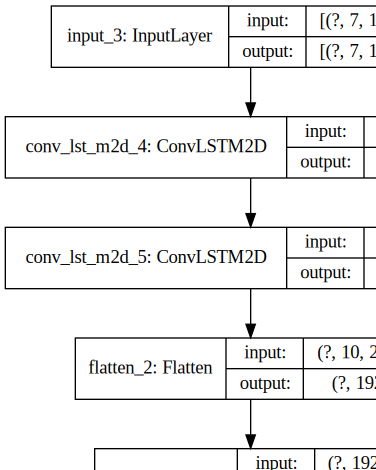

In [31]:
from IPython.display import SVG,display
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import matplotlib.pyplot as plt

#dá erro mas funciona 
#plot_model(model, to_file='model.pdf',show_shapes=True)

modelSVG=SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
display(modelSVG)

In [20]:
!ls -l


total 32212
-rw-r--r-- 1 root root    11297 Dec  6 18:38 CNNLSTM-ROLL-ATTENTION-BF-SPLIT-energie.hist
-rw-r--r-- 1 root root   526640 Dec  6 18:36 CNNLSTM-ROLL-ATTENTION-ROLL-BF-SPLIT-energie.h5
-rw-r--r-- 1 root root    12797 Dec  6 18:39 LSTM-ATTENTION-CONV1D-BF-enegie.pdf
-rw-r--r-- 1 root root     5728 Dec  6 18:31 out-class-size168-step24-norm.csv
drwxr-xr-x 1 root root     4096 Dec  2 22:04 sample_data
-rw-r--r-- 1 root root 32412053 Dec  6 18:34 windows-size168-step24-Normalized.csv


In [32]:
NB_EPOCH = 100
BATCH_SIZE = 64
VERBOSE = 1

#tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
#esCallBack = EarlyStopping(monitor='val_acc', min_delta=0, patience=12, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=5, min_lr=0.0001)
best_checkpoint = ModelCheckpoint('CNNLSTM-energie.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
		batch_size=BATCH_SIZE, epochs=NB_EPOCH, 
		verbose=1, # 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
		validation_data=(X_test,y_test),
		#validation_split=VALIDATION_SPLIT,
		callbacks=[best_checkpoint])

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 1.5620 - accuracy: 0.3133
Epoch 00001: val_accuracy improved from -inf to 0.22378, saving model to CNNLSTM-energie.h5
18/18 [==============================] - 2s 119ms/step - loss: 1.5620 - accuracy: 0.3133 - val_loss: 1.6045 - val_accuracy: 0.2238
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 1.4129 - accuracy: 0.3813
Epoch 00002: val_accuracy improved from 0.22378 to 0.37413, saving model to CNNLSTM-energie.h5
18/18 [==============================] - 2s 97ms/step - loss: 1.4129 - accuracy: 0.3813 - val_loss: 1.4088 - val_accuracy: 0.3741
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 1.3341 - accuracy: 0.4293
Epoch 00003: val_accuracy did not improve from 0.37413
18/18 [==============================] - 2s 88ms/step - loss: 1.3341 - accuracy: 0.4293 - val_loss: 1.3869 - val_accuracy: 0.3741
Epoch 4/100
18/18 [==============================] - ETA: 0s - loss: 1.3106 - accu

In [33]:
import json,codecs
import numpy as np
def saveHist(path,history):
 
    new_hist = {}
    for key in list(history.history.keys()):
        if type(history.history[key]) == np.ndarray:
            new_hist[key] == history.history[key].tolist()
        elif type(history.history[key]) == list:
           #if  type(history.history[key][0]) == np.float64:
           new_hist[key] = list(map(float, history.history[key]))
 
    #print(new_hist)
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(new_hist, f, separators=(',', ':'), sort_keys=True, indent=4) 
 
def loadHist(path):
    with codecs.open(path, 'r', encoding='utf-8') as f:
        n = json.loads(f.read())
    return n
 

saveHist('CNNLSTM-energie.hist',history)
hist=loadHist('CNNLSTM-energie.hist')




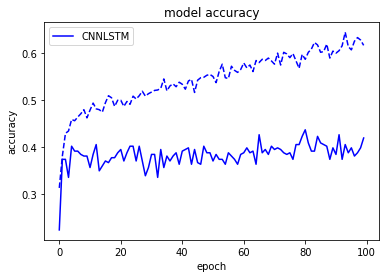

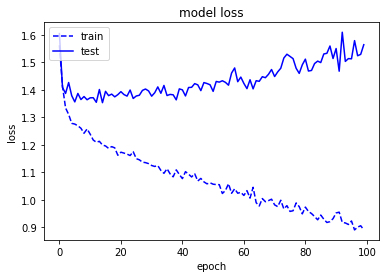

In [34]:
import matplotlib.pylab as plt

acc=np.array(hist['accuracy'])
#acc=acc[0:100]
#acc=np.append(acc,[0.7])
plt.plot(acc,'b--')
plt.plot(hist['val_accuracy'],'b',label='CNNLSTM')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()
# summarize history for loss
loss=np.array(hist['loss'])
#loss=np.append(loss,[2])
plt.plot(loss,'b--',label='train')
plt.plot(hist['val_loss'],'b',label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
from keras.models import load_model
model = load_model('CNNLSTM-energie.h5',custom_objects={'CylindricalPadLSTMCNN':CylindricalPadLSTMCNN})

In [36]:
from sklearn.metrics import classification_report, confusion_matrix

	
print('Confusion Matrix')
cm=confusion_matrix(np.argmax(y_test,axis=1), np.argmax(model.predict(X_test),axis=1))
print(cm)
scores = model.evaluate(X_test,y_test, verbose=0)
print("Dados Validação %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

pred = model.predict(X_test)
predicted = np.argmax(pred, axis=1)
report = classification_report(np.argmax(y_test, axis=1), predicted,digits=4)
print(report)


Confusion Matrix
[[43  6  1  3  2]
 [27 26 14  1  3]
 [11 12 32 11  7]
 [ 3 13 15 17 11]
 [ 5  2  4 10  7]]
Dados Validação accuracy: 43.71%
              precision    recall  f1-score   support

           0     0.4831    0.7818    0.5972        55
           1     0.4407    0.3662    0.4000        71
           2     0.4848    0.4384    0.4604        73
           3     0.4048    0.2881    0.3366        59
           4     0.2333    0.2500    0.2414        28

    accuracy                         0.4371       286
   macro avg     0.4094    0.4249    0.4071       286
weighted avg     0.4324    0.4371    0.4248       286



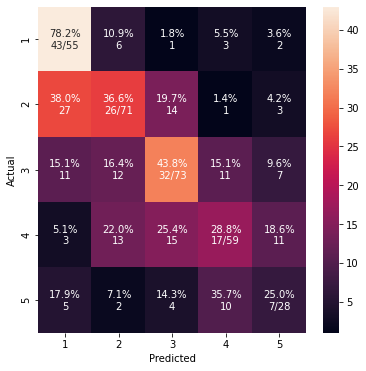

In [37]:
import seaborn as sns

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.savefig("LSTM-ATTENTION-CONV1D-BF-enegie.pdf")
    plt.show()
    
    
    
cm_analysis(np.argmax(y_test,axis=1),np.argmax(pred,axis=1), labels=["1","2","3","4","5"], ymap=None, figsize=(6,6))
